# Import Libraries and functions

In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

pd.set_option('display.max_columns', 300)

%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

import nltk
from nltk import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import re
import string

import scipy
from textblob import TextBlob

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alecmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from tqdm import tqdm
tqdm.pandas()

/Users/alecmccabe/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
import gensim

In [4]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

In [5]:
import gensim
import spacy

nlp = spacy.blank('en')

# Loop through range of all indexes, get words associated with each index.
# The words in the keys list will correspond to the order of the google embed matrix
keys = []
for idx in range(3000000):
    keys.append(wv.index2word[idx])

# Set the vectors for our nlp object to the google news vectors
nlp.vocab.vectors = spacy.vocab.Vectors(data=wv.syn0, keys=keys)

<ipython-input-5-5779fac04ac5>:13: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  nlp.vocab.vectors = spacy.vocab.Vectors(data=wv.syn0, keys=keys)


In [6]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [7]:
#set stopwords and punctuations
stopwords = stopwords.words('english')
stopwords += list(string.punctuation)
stopwords += ["n't", "' '", "'re'","”","``","“","''","’","'s","'re","http","https","char",
              "reuters","wall","street","journal","photo","vice","news","like","time","make"]

In [8]:
def black_txt(token):
    return  token not in stopwords and token not in list(string.punctuation)  and len(token)>3

def clean_txt(text, string = True):
    clean_text = []
    clean_text2 = []
    text = text.lower()
    text = re.sub("'", "",text)
    text = re.sub("\n", "",text)
    text = re.sub("(\\d|\\W)+"," ",text)
    text = re.sub('time magazine','',text)
    text = re.sub('breitbart','',text)
    text = re.sub('click','',text)
    
    clean_text = [ lemmatizer.lemmatize(word, pos="v") for word in word_tokenize(text) if black_txt(word)]
    clean_text2 = [word for word in clean_text if black_txt(word)]
    
    if string == True:
        return " ".join(clean_text2)
    else:
        return clean_text2

# Load data

In [98]:
#load in data
data = pd.read_csv('clean_data2.csv', index_col = 0)

In [99]:
scaler = MinMaxScaler()
data[['polarity','mccphw','mscphw','coleman_index']] = scaler.fit_transform(data[['polarity','mccphw','mscphw','coleman_index']])


In [100]:
import pickle
# Save
with open('normalizer.pickle', 'wb') as f:
    pickle.dump(scaler, f)

In [101]:
data = pd.get_dummies(data,prefix='topic',columns=['dominant_topic'])

# Build Class Transformers, Pipeline

In [102]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer

In [103]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

    
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pol':  row['polarity'], 
                 'sub': row['subjectivity'],
                 'n_long_words': row['n_long_words'], 
                 'n_monosyllable_words': row['n_monosyllable_words'], 
                 'n_polysyllable_words': row['n_polysyllable_words'], 
                 'n_unique_words': row['n_unique_words'],
                 'coleman_index': row['coleman_index'], 
                 'mccphw': row['mccphw'],
                 'mscphw': row['mscphw'],
                 'profanity': row['profanity']} for _, row in data.iterrows()]

In [104]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('text', Pipeline([
                ('selector', ItemSelector(key='predictor')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 
                                               'subjectivity', 
                                              'n_long_words',
                                              'n_monosyllable_words',
                                              'n_polysyllable_words',
                                              'n_unique_words',
                                               'coleman_index',
                                               'mccphw',
                                               'mscphw',
                                               'profanity'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'text': .5,
            'stats': 2,
        },
    ))
])

In [105]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
seed = 40
X = data[['predictor', 'polarity', 'subjectivity','n_long_words','n_monosyllable_words',
         'n_polysyllable_words','n_unique_words','coleman_index','mccphw','mscphw','profanity']]

y = data['target']
# encoder = LabelEncoder()
# y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [106]:
pipeline.fit(x_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='predictor')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               3),
                                                                                  preprocessor=<function clean_txt at 0x27e983040>,
                                                                                  smooth_idf=1,
                                                       

In [18]:
import pickle
with open('pipeline.pickle', 'wb') as f:
    pickle.dump(pipeline, f)

In [107]:
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the number of features in train and test correspond: (12716, 427106) - (3179, 427106)
CPU times: user 1min 34s, sys: 340 ms, total: 1min 34s
Wall time: 1min 35s


# tSNE Analysis

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(train_vec)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12716 samples in 0.031s...
[t-SNE] Computed neighbors for 12716 samples in 14.332s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12716
[t-SNE] Computed conditional probabilities for sample 2000 / 12716
[t-SNE] Computed conditional probabilities for sample 3000 / 12716
[t-SNE] Computed conditional probabilities for sample 4000 / 12716
[t-SNE] Computed conditional probabilities for sample 5000 / 12716
[t-SNE] Computed conditional probabilities for sample 6000 / 12716
[t-SNE] Computed conditional probabilities for sample 7000 / 12716
[t-SNE] Computed conditional probabilities for sample 8000 / 12716
[t-SNE] Computed conditional probabilities for sample 9000 / 12716
[t-SNE] Computed conditional probabilities for sample 10000 / 12716
[t-SNE] Computed conditional probabilities for sample 11000 / 12716
[t-SNE] Computed conditional probabilities for sample 12000 / 12716
[t-SNE] Computed conditional probabilities for s

In [22]:
placeholder = {}
placeholder['one'] = tsne_results[:,0]
placeholder['two'] = tsne_results[:,1]
placeholder['three'] = tsne_results[:,2]
placeholder_df = pd.DataFrame(placeholder)

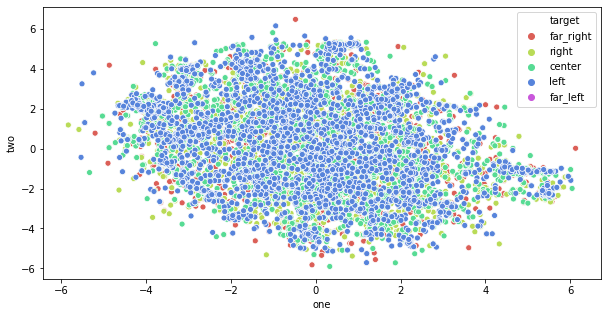

In [23]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    x="one", y="two",
    hue=y_train,
    palette=sns.color_palette("hls", 5),
    data=placeholder_df,
    legend="full")

plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/tSNE.png')
plt.show()

# Test different models

In [24]:
from sklearn.metrics import plot_confusion_matrix

In [25]:
results = pd.DataFrame(columns = ['model','accuracy'])
results

,model,accuracy


In [26]:
new_row = {'model': 'Dummy', 'accuracy': .291961}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961


------------

In [27]:
from sklearn.calibration import CalibratedClassifierCV

In [28]:
#Linear Support Vector Machines
lin_svc = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40,verbose=3) 
svc_cal = CalibratedClassifierCV(lin_svc) 

svc_cal.fit(train_vec, y_train)
test_preds = svc_cal.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'SVM', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104


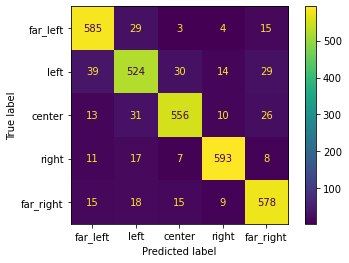

In [29]:
plot_confusion_matrix(svc_cal,test_vec,y_test, labels=['far_left','left','center','right','far_right'])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/svm_confusion.png')


In [30]:
with open('model.pickle', 'wb') as f:
    pickle.dump(svc_cal, f)

------------

In [31]:
#Random Forest - best so far is 500 trees with sqrt max features
rfc_clf = RandomForestClassifier(n_estimators=200,max_features='sqrt',random_state=0,n_jobs=-1,verbose=1)
rfc_clf.fit(train_vec, y_train)
test_preds = rfc_clf.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'RFC', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   26.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


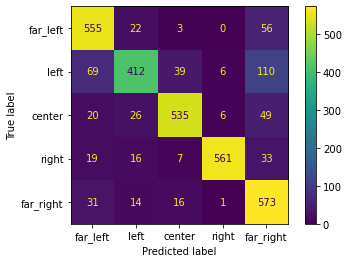

In [32]:
plot_confusion_matrix(rfc_clf,test_vec,y_test, labels=['far_left','left','center','right','far_right'])

------------

In [33]:
#Multinomial Bayes
mnb_lemma = MultinomialNB(alpha = 0.0000001)
mnb_lemma.fit(train_vec, y_train)
test_preds = mnb_lemma.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'MNB', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570


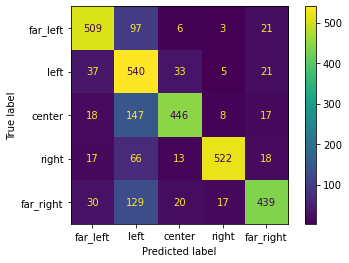

In [34]:
plot_confusion_matrix(mnb_lemma,test_vec,y_test, labels=['far_left','left','center','right','far_right'])

----------

In [35]:
#Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(C = 5, random_state=0, n_jobs=-1)

pac.fit(train_vec, y_train)
test_preds = pac.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'PAC', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.892734


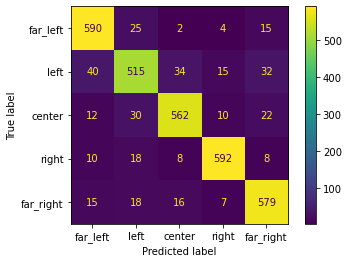

In [36]:
plot_confusion_matrix(pac,test_vec,y_test,labels=['far_left','left','center','right','far_right'])

-----

In [37]:
#bagging classifier
bc_lr = BaggingClassifier(
            base_estimator=LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40,verbose=3))

bc_lr.fit(train_vec, y_train)
test_preds = bc_lr.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

new_row = {'model': 'Bag', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.892734
5,Bag,0.878893


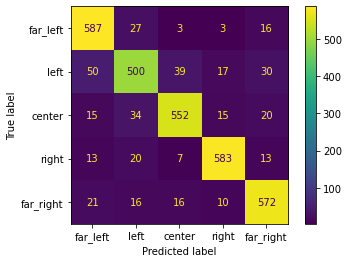

In [38]:
plot_confusion_matrix(bc_lr,test_vec,y_test,labels=['far_left','left','center','right','far_right'])

-----

In [108]:
#XGBoost
xg_clf = xgb.XGBClassifier(objective ='multi:softmax', 
                           booster='gbtree',
                           colsample_bytree = .1,
                           random_state=0,
                          n_estimators=1000,
                          n_jobs=-1)

xg_clf.fit(train_vec, y_train)
test_preds = xg_clf.predict(test_vec)

accuracy = accuracy_score(y_test, test_preds)

In [109]:
accuracy

0.897137464611513

In [41]:
new_row = {'model': 'XGB', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.892734
5,Bag,0.878893
6,XGB,0.897137


In [42]:
with open('model.pickle', 'wb') as f:
    pickle.dump(xg_clf, f)

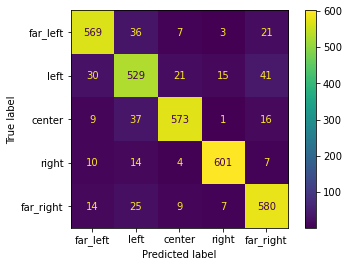

In [43]:
plot_confusion_matrix(xg_clf,test_vec,y_test, labels=['far_left','left','center','right','far_right'])
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/xgb_confusion.png')


In [97]:
xg_clf.

<bound method XGBModel.get_xgb_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>

--------

**Test out Word2Vec**

In [44]:
class SpacyVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        # Doc.vector defaults to an average of the token vectors.
        # https://spacy.io/api/doc#vector
        
        return [self.nlp(text).vector for text in X]

In [45]:
X = data['predictor']
y =data['target']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [46]:
embeddings_pipeline = Pipeline(
    steps=[
        ("mean_embeddings", SpacyVectorTransformer(nlp)),
        ("reduce_dim", TruncatedSVD(50)),
        ("classifier", PassiveAggressiveClassifier(C=5,random_state=0,n_jobs=-1, verbose=1)),
    ]
)
embeddings_pipeline.fit(x_train, y_train)
y_pred = embeddings_pipeline.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)

new_row = {'model': 'word2vec', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


-- Epoch 1-- Epoch 1
-- Epoch 1-- Epoch 1


-- Epoch 1
Norm: 122.60, NNZs: 50, Bias: 1.010124, T: 12716, Avg. loss: 0.994460
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 104.66, NNZs: 50, Bias: 2.648298, T: 12716, Avg. loss: 1.106492
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 114.44, NNZs: 50, Bias: -1.796805, T: 12716, Avg. loss: 1.115509Norm: 154.91, NNZs: 50, Bias: -0.996315, T: 12716, Avg. loss: 0.822428
Total training time: 0.00 seconds.
-- Epoch 2

Total training time: 0.01 seconds.
-- Epoch 2
Norm: 96.01, NNZs: 50, Bias: -14.280058, T: 12716, Avg. loss: 1.120977
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 152.12, NNZs: 50, Bias: -2.581856, T: 25432, Avg. loss: 1.040707Norm: 167.04, NNZs: 50, Bias: 0.218855, T: 25432, Avg. loss: 0.917771
Total training time: 0.01 seconds.
-- Epoch 3

Total training time: 0.01 seconds.
-- Epoch 3
Norm: 210.52, NNZs: 50, Bias: 0.412185, T: 25432, Avg. loss: 0.555242Norm: 177.72, NNZs: 50, Bias: -1.489916, T: 25432, Avg. loss

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.892734
5,Bag,0.878893
6,XGB,0.897137
7,word2vec,0.486631


-----

**Deep Learning, Spacy**

In [63]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

In [64]:
from sklearn.model_selection import train_test_split
import time
X = data['predictor']
y =data['target']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
Y = np_utils.to_categorical(y)
##Create the tf-idf vector
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = None, preprocessor=clean_txt)

In [65]:
seed = 40
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify =y)
vectorizer.fit(x_train)

TfidfVectorizer(max_df=0.2, min_df=3,
                preprocessor=<function clean_txt at 0x27e983040>, smooth_idf=1,
                strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [66]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()
 
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]
print(X_train_sequences[0])

[24873, 4355, 987, 18881, 4335, 1520, 10099, 24874, 16012, 14033, 4355, 1660, 15741, 3168, 14033, 10828, 17184, 19028, 15663, 17477, 11750, 9090, 21866, 9035, 21684, 14033, 2682, 1742, 7051, 25082, 3384, 11867, 10871, 22343, 3668, 24873, 24874, 16012, 14033, 1842, 1520, 4335, 987, 10099, 2258, 18881, 18697, 3664, 21643, 13337, 1842, 8979, 14033, 10828, 16969, 2775, 17184, 19028, 15663, 2627, 5977, 15741, 3168, 23174, 11292, 8832, 2798, 824, 1744, 19920, 7911, 16027, 25079, 9728, 4612, 14033, 11972, 5461, 2682, 1742, 315, 15840, 4640, 6372, 12157, 24418, 9329, 4817, 12155, 6169, 18881, 14033, 18097, 14696, 8832, 25010, 5308, 10099, 22843, 18400, 956, 5998, 22651, 1742, 2258, 15796, 24876, 17979, 4339, 20790, 9035, 1520, 12885, 7486, 16728, 1749, 13178, 4335, 1520, 11226, 13910, 2457, 9090, 21866, 9035, 21684, 8935, 2182, 10005, 2431, 12544, 7348, 15115, 11971, 6500, 14033, 13529, 24873, 4355, 19722, 16582, 20963, 12182, 581, 14958, 824, 15115, 24873, 16582, 9653, 3664, 14033, 24873, 615

In [72]:
# Compute the max lenght of a text

MAX_SEQ_LENGHT=500

N_FEATURES = len(vectorizer.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082 26082
 26082 24873  4355   987 18881  4335  1520 10099 24874 16012 14033  4355
  1660 15741  3168 14033 10828 17184 19028 15663 17477 11750  9090 21866
  9035 21684 14033  2682  1742  7051 25082  3384 11867 10871 22343  3668
 24873 24874 16012 14033  1842  1520  4335   987 10099  2258 18881 18697
  3664 21643 13337  1842  8979 14033 10828 16969  2

In [73]:
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

In [74]:
EMBEDDINGS_LEN = 300

embeddings_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)

EMBEDDINGS_LEN= 300


In [76]:
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(300, dropout=0.2))
model.add(Dense(len(set(y)), activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          7824900   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 1505      
Total params: 8,547,605
Trainable params: 722,705
Non-trainable params: 7,824,900
_________________________________________________________________
None


In [77]:
model.fit(X_train_sequences, y_train, 
          epochs=5, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate(X_test_sequences, y_test, verbose=1)
print("Accuracy:", scores[1])


Epoch 1/5
24/90 [=======>......................] - ETA: 1:58 - loss: 1.5667 - accuracy: 0.3011

KeyboardInterrupt: 

In [56]:
accuracy = scores[1]

new_row = {'model': 'LSTM-Simple', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.892734
5,Bag,0.878893
6,XGB,0.897137
7,word2vec,0.486631
8,LSTM-Simple,0.532557


------

**LSTM with new features**

In [57]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(10,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(300, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 60, 300)      7824900     text[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300)          721200      embedding_1[0][0]                
__________________________________________________________________________________________________
meta (InputLayer)               [(None, 10)]         0                                            
_______________________________________________________________________________________

In [58]:
df_cat_train = data.iloc[x_train.index][['polarity', 'subjectivity', 'topic_0',
                                        'topic_1',
                                        'topic_2',
                                        'topic_3',
                                        'topic_4',
                                        'topic_5',
                                        'topic_6',
                                        'topic_7']]
df_cat_test = data.iloc[x_test.index][['polarity', 'subjectivity', 'topic_0',
                                        'topic_1',
                                        'topic_2',
                                        'topic_3',
                                        'topic_4',
                                        'topic_5',
                                        'topic_6',
                                        'topic_7']]

In [59]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=12, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  

Epoch 1/12
90/90 [==============================] - 46s 510ms/step - loss: 1.4132 - accuracy: 0.4249 - val_loss: 1.5395 - val_accuracy: 0.3734
Epoch 2/12
90/90 [==============================] - 45s 501ms/step - loss: 1.1826 - accuracy: 0.5282 - val_loss: 1.4668 - val_accuracy: 0.3994
Epoch 3/12
90/90 [==============================] - 43s 482ms/step - loss: 1.1082 - accuracy: 0.5622 - val_loss: 1.3918 - val_accuracy: 0.4756
Epoch 4/12
90/90 [==============================] - 46s 509ms/step - loss: 1.0306 - accuracy: 0.5938 - val_loss: 1.2488 - val_accuracy: 0.5660
Epoch 5/12
90/90 [==============================] - 45s 499ms/step - loss: 0.9896 - accuracy: 0.6134 - val_loss: 1.1775 - val_accuracy: 0.5354
Epoch 6/12
90/90 [==============================] - 45s 501ms/step - loss: 0.9302 - accuracy: 0.6408 - val_loss: 1.1116 - val_accuracy: 0.5401
Epoch 7/12
90/90 [==============================] - 44s 491ms/step - loss: 0.8923 - accuracy: 0.6559 - val_loss: 1.1182 - val_accuracy: 0.5582

In [60]:
accuracy = scores[1]

new_row = {'model': 'LSTM-MetaFeatures', 'accuracy': accuracy}
results = results.append(new_row, ignore_index=True)
results

,model,accuracy
0,Dummy,0.291961
1,SVM,0.892104
2,RFC,0.829192
3,MNB,0.772570
4,PAC,0.892734
5,Bag,0.878893
6,XGB,0.897137
7,word2vec,0.486631
8,LSTM-Simple,0.532557
9,LSTM-MetaFeatures,0.645171


In [61]:
results = results.sort_values(by='accuracy', ascending=True)
results.reset_index(drop=True, inplace=True)

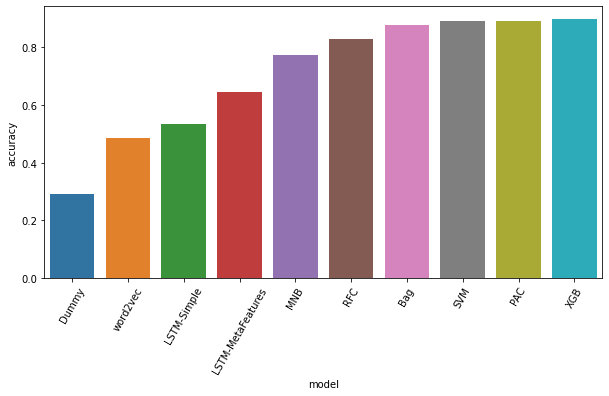

In [62]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x=results.model, y=results.accuracy, data=results)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
plt.savefig('/Users/alecmccabe/Desktop/Flatiron/Projects/final_project_ideas/web_articles_spin/Pics/model_evaluation.png')

plt.show()